In [5]:
import csv
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.pipeline import Pipeline
from sklearn.datasets import make_classification, load_breast_cancer
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import LeaveOneGroupOut
from tabulate import tabulate
from sklearn.neural_network import MLPClassifier

/Volumes/eegrvw/Imaging/Multimodal/MRF/Recon_MRF_3T/Patients/P102_15731/MRF_VBM


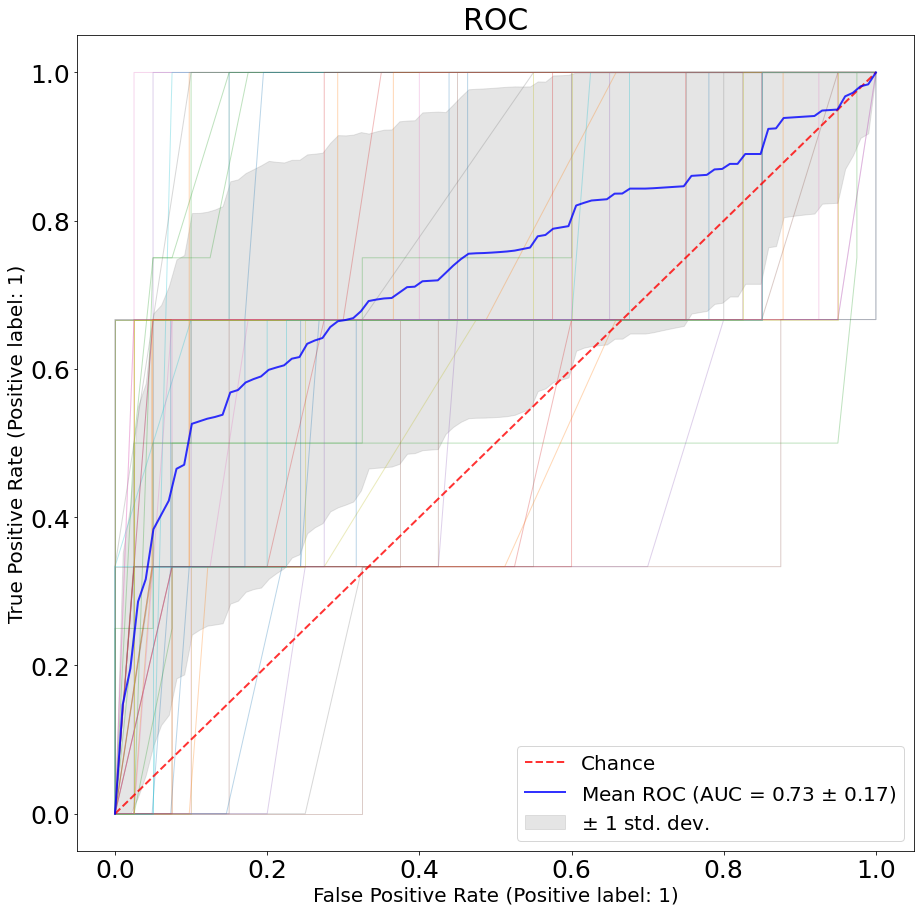

TP 1.0 FP 1.0
[0.82050986 0.82405804 0.82726952 0.8281241  0.82897868 0.83649992
 0.83666667 0.84333333 0.84333333 0.84333333 0.84380471 0.84447811
 0.84515152 0.84582492 0.84649832 0.86050505 0.86117845 0.86185185
 0.86919192 0.86986532 0.87666667 0.87666667 0.89       0.89
 0.89       0.92390572 0.92457912 0.93858586 0.93925926 0.93993266
 0.94060606 0.94127946 0.94861953 0.94929293 0.94996633 0.96781145
 0.97252525 0.98127946 0.98397306 1.        ]
[0.60606061 0.61616162 0.62626263 0.63636364 0.64646465 0.65656566
 0.66666667 0.67676768 0.68686869 0.6969697  0.70707071 0.71717172
 0.72727273 0.73737374 0.74747475 0.75757576 0.76767677 0.77777778
 0.78787879 0.7979798  0.80808081 0.81818182 0.82828283 0.83838384
 0.84848485 0.85858586 0.86868687 0.87878788 0.88888889 0.8989899
 0.90909091 0.91919192 0.92929293 0.93939394 0.94949495 0.95959596
 0.96969697 0.97979798 0.98989899 1.        ]


In [127]:
%cd /Volumes/eegrvw/Imaging/Multimodal/MRF/Recon_MRF_3T/Patients/(studyID)/MRF_VBM

X = pd.read_excel('unnorm_trainingatpoint0old_Bronly.xlsx').values[:,0:6]
y = pd.read_excel('unnorm_trainingatpoint0old_Bronly.xlsx').values[:,8].astype(int)
pts = pd.read_excel('unnorm_trainingatpoint0old_Bronly.xlsx').values[:,6]
sutys = pd.read_excel('unnorm_trainingatpoint0old_Bronly.xlsx').values[:,7]


# X = pd.read_excel('preds_norm_1.xlsx').values[:,0:5]
# y = pd.read_excel('preds_norm_1.xlsx').values[:,8].astype(int)
# pts = pd.read_excel('preds_norm_1.xlsx').values[:,6]
# sutys = pd.read_excel('preds_norm_1.xlsx').values[:,7]

fplobes_after_prediction = np.array([])
tplobes_after_prediction = np.array([])

GlobalRandomStateSeed=123
rskf = RepeatedStratifiedKFold(n_splits=10, n_repeats=5,
    random_state=GlobalRandomStateSeed) #10-fold-stratified-CV, repeated 2 times


steps = [('over', ADASYN()), ('model',  svm.SVC(kernel="linear", probability=False,
                     random_state=GlobalRandomStateSeed))]

mlp = MLPClassifier(hidden_layer_sizes=(10,10), max_iter=3000,activation = 'tanh',solver='adam',random_state=123, learning_rate='adaptive')
steps = [('over', ADASYN()), ('mlpc', mlp)]

# from sklearn.tree import DecisionTreeClassifier
# decision_tree = DecisionTreeClassifier(random_state=1, max_depth=3)
# steps = [('over', SMOTE()), ('model',decision_tree)]

pipeline = Pipeline(steps=steps)
tprs = []
aucs = []
cm = np.zeros((2,2))
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize=(15, 15))
for i, (train, test) in enumerate(rskf.split(X, y)):
    pipeline.fit(X[train], y[train])
    viz = RocCurveDisplay.from_estimator(pipeline, X[test], y[test],
                        #  name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)
#     print(pipeline.named_steps['model'].coef_.flatten())
    y_pred = pipeline.predict(X[test])
    y_pred = y_pred.reshape(y[test].shape)

#     threshold = 0.3
#     y_pred = (pipeline.predict_proba(X[test])[:, 1] > threshold).astype('float')  
#     y_pred = y_pred.reshape(y[test].shape)
    cm += confusion_matrix(y[test], y_pred)
        
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

plt.rc('font', size=30)          # controls default text sizes
plt.rc('axes', titlesize=30)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=25)    # fontsize of the tick labels
plt.rc('ytick', labelsize=25)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=30)  # fontsize of the figure title
ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="ROC")
ax.legend(loc="lower right")
plt.gcf()
handles, labels = plt.gca().get_legend_handles_labels()
handles = handles[50:]
labels = labels[50:]
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.show()
f1TP = mean_tpr*(cm[0,0]+cm[1,0])
f1FP = mean_fpr*(cm[1,1]+cm[0,1])
f1FN = (1-mean_tpr)*(cm[1,0]+cm[0,0])
f1s = f1TP/(f1TP+0.5*(f1FP+f1FN))
optthresh = np.argmax(f1s)
print('TP', mean_tpr[optthresh], 'FP', mean_fpr[optthresh])
print(mean_tpr[mean_tpr>=0.8])
print(mean_fpr[mean_tpr>=0.8])


[WinError 3] The system cannot find the path specified: '/Volumes/eegrvw/Imaging/Multimodal/MRF/Recon_MRF_3T/Patients/P102_15731/MRF_VBM'
Z:\Imaging\Multimodal\MRF\Recon_MRF_3T\Patients\P102_15731\MRF_VBM


AttributeError: type object 'RocCurveDisplay' has no attribute 'from_estimator'

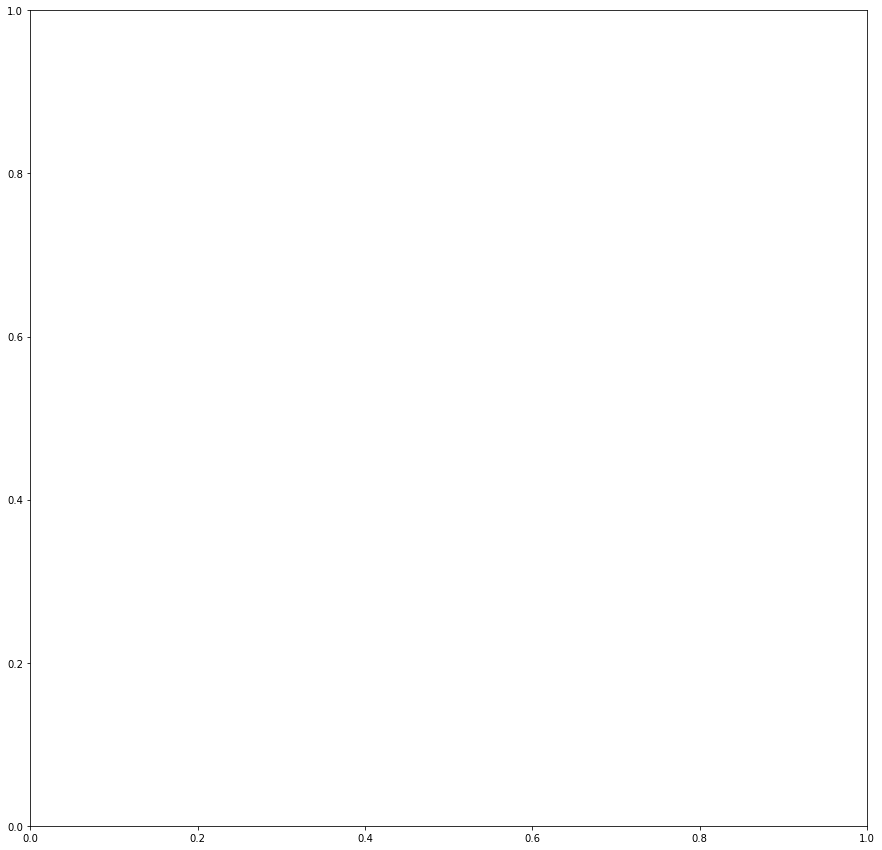

In [8]:
%cd /Volumes/eegrvw/Imaging/Multimodal/MRF/Recon_MRF_3T/Patients/(studyID)/MRF_VBM

X = pd.read_excel('norm_trainingatpoint0old_Bronly.xlsx').values[:,0:6]
y = pd.read_excel('norm_trainingatpoint0old_Bronly.xlsx').values[:,8].astype(int)
pts = pd.read_excel('norm_trainingatpoint0old_Bronly.xlsx').values[:,6]
sutys = pd.read_excel('norm_trainingatpoint0old_Bronly.xlsx').values[:,7]


fplobes_after_prediction = np.array([])
tplobes_after_prediction = np.array([])

GlobalRandomStateSeed=123
rskf = RepeatedStratifiedKFold(n_splits=10, n_repeats=5,
    random_state=GlobalRandomStateSeed) #10-fold-stratified-CV, repeated 2 times


# steps = [('over', ADASYN()), ('model',  svm.SVC(kernel="linear", probability=False,
#                      random_state=GlobalRandomStateSeed))]
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(10,10), max_iter=2000,activation = 'tanh',solver='adam',random_state=123, learning_rate='adaptive')
steps = [('over', ADASYN()), ('mlpc', mlp)]

# from sklearn.tree import DecisionTreeClassifier
# decision_tree = DecisionTreeClassifier(random_state=1, max_depth=3)
# steps = [('over', SMOTE()), ('model',decision_tree)]

pipeline = Pipeline(steps=steps)
tprs = []
aucs = []
cm = np.zeros((2,2))
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize=(15, 15))
for i, (train, test) in enumerate(rskf.split(X, y)):
    pipeline.fit(X[train], y[train])
    viz = RocCurveDisplay.from_estimator(pipeline, X[test], y[test], alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)
#     print(pipeline.named_steps['model'].coef_.flatten())
    y_pred = pipeline.predict(X[test])
    y_pred = y_pred.reshape(y[test].shape)

#     threshold = 0.3
#     y_pred = (pipeline.predict_proba(X[test])[:, 1] > threshold).astype('float')  
#     y_pred = y_pred.reshape(y[test].shape)
    cm += confusion_matrix(y[test], y_pred)
        
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

plt.rc('font', size=30)          # controls default text sizes
plt.rc('axes', titlesize=30)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=25)    # fontsize of the tick labels
plt.rc('ytick', labelsize=25)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=30)  # fontsize of the figure title
ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="ROC")
ax.legend(loc="lower right")

plt.gcf()
handles, labels = plt.gca().get_legend_handles_labels()
handles = handles[50:]
labels = labels[50:]
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.show()
f1TP = mean_tpr*(cm[0,0]+cm[1,0])
f1FP = mean_fpr*(cm[1,1]+cm[0,1])
f1FN = (1-mean_tpr)*(cm[1,0]+cm[0,0])
f1s = f1TP/(f1TP+0.5*(f1FP+f1FN))
optthresh = np.argmax(f1s)
print('TP', mean_tpr[optthresh], 'FP', mean_fpr[optthresh])
print(mean_tpr[mean_tpr>=0.8])
print(mean_fpr[mean_tpr>=0.8])

/Volumes/eegrvw/Imaging/Multimodal/MRF/Recon_MRF_3T/Patients/P102_15731/MRF_VBM
[ 0.00494427  0.45103326 -0.87035946  1.15772039  0.42015635  0.98596305]
[ 0.02369509  0.68592459 -0.94175256  1.11430557  0.92674393  0.16952416]
[-0.14439167  0.82963262 -0.76632854  0.88354146  0.94416394  0.23490354]
[-0.10561356  0.73836209 -1.54737154  1.36969754  1.0184932   0.41175725]
[-0.57872811  1.09110352 -0.17526441  0.60703248  0.91379969  0.24814807]
[ 0.64901544  0.02109804 -1.56384197  1.39424007  0.9215923   0.25602204]
[-0.15411209  0.81588828 -0.84469401  1.10286649  1.00701184 -0.11975209]
[ 0.6193932   0.0434951  -1.13070648  1.29031588  0.91113435  0.39643364]
[ 0.17309186  0.40982252 -0.67890069  1.1009556   0.9818414   0.18575234]
[ 0.01355773  0.76223514 -0.72103295  0.69324285  0.86463319  0.50516573]
[[ 0.05008522  0.58485952 -0.92402526  1.07139183  0.89095702  0.32739177]]
[[0.48817387 0.75617513 0.         1.         0.90957539 0.62714559]]


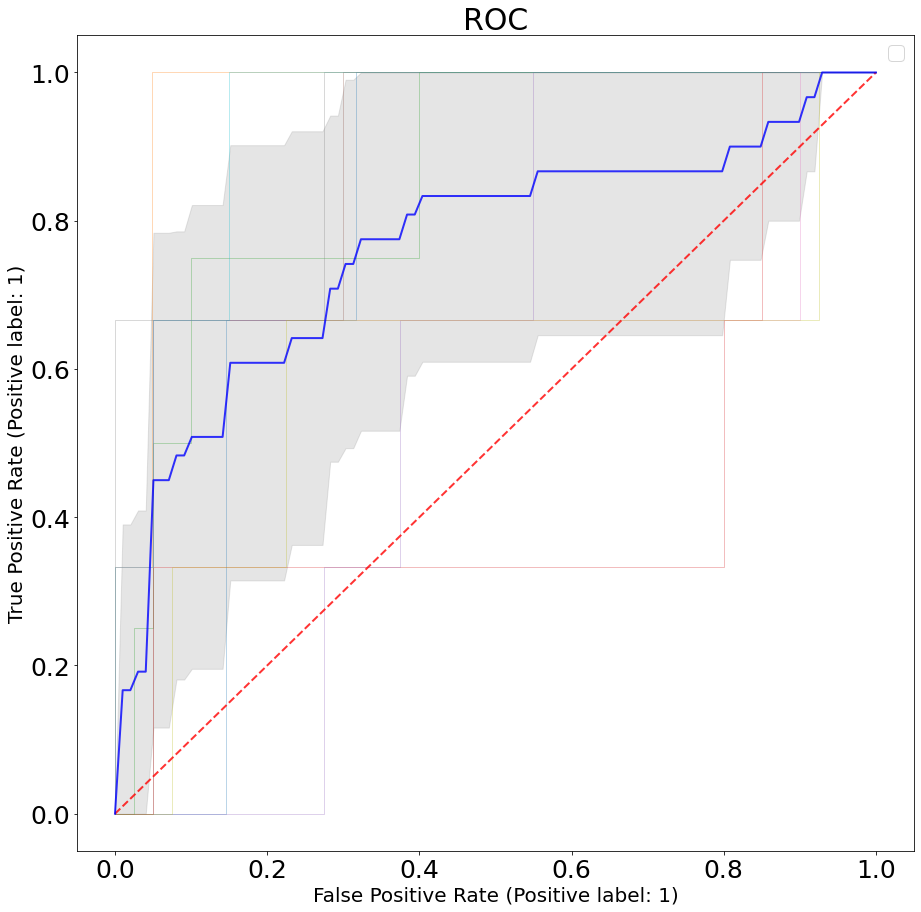

TP 1.0 FP 0.9292929292929294
[0.80833333 0.80833333 0.83333333 0.83333333 0.83333333 0.83333333
 0.83333333 0.83333333 0.83333333 0.83333333 0.83333333 0.83333333
 0.83333333 0.83333333 0.83333333 0.83333333 0.83333333 0.86666667
 0.86666667 0.86666667 0.86666667 0.86666667 0.86666667 0.86666667
 0.86666667 0.86666667 0.86666667 0.86666667 0.86666667 0.86666667
 0.86666667 0.86666667 0.86666667 0.86666667 0.86666667 0.86666667
 0.86666667 0.86666667 0.86666667 0.86666667 0.86666667 0.86666667
 0.9        0.9        0.9        0.9        0.9        0.93333333
 0.93333333 0.93333333 0.93333333 0.93333333 0.96666667 0.96666667
 1.         1.         1.         1.         1.         1.
 1.         1.        ]
[0.38383838 0.39393939 0.4040404  0.41414141 0.42424242 0.43434343
 0.44444444 0.45454545 0.46464646 0.47474747 0.48484848 0.49494949
 0.50505051 0.51515152 0.52525253 0.53535354 0.54545455 0.55555556
 0.56565657 0.57575758 0.58585859 0.5959596  0.60606061 0.61616162
 0.62626263 0.636

In [141]:
# get coefficients
%cd /Volumes/eegrvw/Imaging/Multimodal/MRF/Recon_MRF_3T/Patients/P102/MRF_VBM

X = pd.read_excel('norm_trainingatpoint0old_Bronly.xlsx').values[:,0:6]
y = pd.read_excel('norm_trainingatpoint0old_Bronly.xlsx').values[:,8].astype(int)
pts = pd.read_excel('norm_trainingatpoint0old_Bronly.xlsx').values[:,6]
sutys = pd.read_excel('norm_trainingatpoint0old_Bronly.xlsx').values[:,7]

X[:,4] /= 1000 
X[:,5] /= 1000 

fplobes_after_prediction = np.array([])
tplobes_after_prediction = np.array([])

GlobalRandomStateSeed=123
rskf = RepeatedStratifiedKFold(n_splits=10, n_repeats=1,
    random_state=GlobalRandomStateSeed) #10-fold-stratified-CV, repeated 2 times


steps = [('over', ADASYN()), ('model',  svm.SVC(kernel="linear", probability=False,
                     random_state=GlobalRandomStateSeed))]
# from sklearn.neural_network import MLPClassifier
# mlp = MLPClassifier(hidden_layer_sizes=(10,10), max_iter=2000,activation = 'tanh',solver='adam',random_state=123, learning_rate='adaptive')
# steps = [('over', ADASYN()), ('mlpc', mlp)]

pipeline = Pipeline(steps=steps)
tprs = []
aucs = []
coefs = np.zeros((1,6))
cm = np.zeros((2,2))
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize=(15, 15))
for i, (train, test) in enumerate(rskf.split(X, y)):
    pipeline.fit(X[train], y[train])
    viz = RocCurveDisplay.from_estimator(pipeline, X[test], y[test], alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)
    print(pipeline.named_steps['model'].coef_.flatten())
    coefs += pipeline.named_steps['model'].coef_.flatten()
    y_pred = pipeline.predict(X[test])
    y_pred = y_pred.reshape(y[test].shape)

#     threshold = 0.3
#     y_pred = (pipeline.predict_proba(X[test])[:, 1] > threshold).astype('float')  
#     y_pred = y_pred.reshape(y[test].shape)
    cm += confusion_matrix(y[test], y_pred)
coefs /= 10
print(coefs)
print((coefs-np.min(coefs))/(np.max(coefs)-np.min(coefs)))
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

plt.rc('font', size=30)          # controls default text sizes
plt.rc('axes', titlesize=30)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=25)    # fontsize of the tick labels
plt.rc('ytick', labelsize=25)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=30)  # fontsize of the figure title
ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="ROC")
ax.legend(loc="lower right")

plt.gcf()
handles, labels = plt.gca().get_legend_handles_labels()
handles = handles[50:]
labels = labels[50:]
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.show()
f1TP = mean_tpr*(cm[0,0]+cm[1,0])
f1FP = mean_fpr*(cm[1,1]+cm[0,1])
f1FN = (1-mean_tpr)*(cm[1,0]+cm[0,0])
f1s = f1TP/(f1TP+0.5*(f1FP+f1FN))
optthresh = np.argmax(f1s)
print('TP', mean_tpr[optthresh], 'FP', mean_fpr[optthresh])
print(mean_tpr[mean_tpr>=0.8])
print(mean_fpr[mean_tpr>=0.8])

In [139]:
coefs

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]])

/Volumes/eegrvw/Imaging/Multimodal/MRF/Recon_MRF_3T/Patients/P102_15731/MRF_VBM
Patient: P100_15582, Subtype: mMCD, Truth: [0 0 1 0 0], Prediction: [0. 0. 0. 0. 0.]
not detected
Patient: P101_15675, Subtype: IIB, Truth: [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0], Prediction: [0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Patient: P102_15731, Subtype: mMCD, Truth: [0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0], Prediction: [1. 1. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0.
 0. 1. 0.]
Patient: P10_12479, Subtype: MOGHE, Truth: [0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0], Prediction: [1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
Patient: P11_12483, Subtype: IIB, Truth: [0 0 0 0 0 0 0 0 0 1 0 0 0], Prediction: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1.]
Patient: P12_12515, Subtype: mMCD, Truth: [0 0 0 0 0 0], Prediction: [0. 1. 0. 0. 0. 0.]


/Users/irene/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1016: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


Patient: P15_12610, Subtype: IIB, Truth: [0 0 0 0 1], Prediction: [0. 0. 0. 0. 1.]
Patient: P16_12669, Subtype: IIB, Truth: [0 0 1 0 0 0], Prediction: [0. 0. 1. 1. 0. 0.]


/Users/irene/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1016: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


Patient: P17_12709, Subtype: mMCD, Truth: [0 0 0 0 0 0 0 0 0 0], Prediction: [1. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
Patient: P18_12713, Subtype: mMCD, Truth: [0 1 0 0 0 0 0 0 0], Prediction: [1. 1. 0. 0. 0. 0. 0. 0. 1.]
Patient: P19_12748, Subtype: IIA, Truth: [0 0 0 0 0 0 1 0], Prediction: [1. 0. 0. 1. 1. 1. 1. 0.]
Patient: P21_12791, Subtype: IIA, Truth: [0 0 0 0 0 0 0 0 1], Prediction: [1. 0. 0. 1. 1. 0. 0. 1. 1.]
Patient: P22_12836, Subtype: IIA, Truth: [0 0 0 0 1], Prediction: [0. 1. 0. 1. 1.]
Patient: P23_12911, Subtype: IIB, Truth: [0 0 0 1 0 0 0 0 0 0], Prediction: [0. 0. 0. 1. 0. 1. 0. 0. 0. 1.]
Patient: P24_13157, Subtype: IIA, Truth: [0 0 0 0 0 0 1 0 0 0 0 0 0], Prediction: [1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 0. 0. 0.]
Patient: P31_13375, Subtype: IIB, Truth: [1 0 0 0 0 0 0 0 0], Prediction: [1. 0. 1. 0. 1. 0. 1. 0. 0.]
Patient: P32_13395, Subtype: mMCD, Truth: [0 0 0], Prediction: [0. 0. 1.]


/Users/irene/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1016: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/irene/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1016: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


Patient: P33_13509, Subtype: mMCD, Truth: [0 0 0 0 0 0 0 0 0], Prediction: [1. 0. 1. 0. 1. 1. 1. 0. 0.]
Patient: P41_13696, Subtype: MOGHE, Truth: [0 0 0 1 0 0 0 0 0 0 0 0], Prediction: [0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0.]


/Users/irene/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1016: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


Patient: P42_13702, Subtype: IIB, Truth: [0 0], Prediction: [0. 0.]


/Users/irene/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1016: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


Patient: P43_13706, Subtype: MOGHE, Truth: [0 0 0 0 0], Prediction: [1. 0. 0. 1. 0.]


/Users/irene/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1016: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/irene/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1016: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


Patient: P45_13724, Subtype: IIA, Truth: [0 0 0 0 0 0 0 0 0], Prediction: [0. 1. 0. 0. 1. 0. 0. 0. 0.]
Patient: P46_13728, Subtype: IIB, Truth: [0 0 0 0 0 0 0 0], Prediction: [1. 0. 0. 1. 1. 0. 1. 0.]
Patient: P52_13923, Subtype: IIB, Truth: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1], Prediction: [1. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1.]


/Users/irene/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1016: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


Patient: P56_14105, Subtype: IIB, Truth: [0 0 0 0 0], Prediction: [0. 0. 0. 1. 0.]
Patient: P57_14129, Subtype: IIB, Truth: [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0], Prediction: [0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 1.]
Patient: P62_14212, Subtype: IIA, Truth: [0 0 0 0 0 0 0 0 1 0 0 0], Prediction: [0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0.]
Patient: P63_14218, Subtype: IIA, Truth: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0], Prediction: [1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0.]
Patient: P68_14287, Subtype: mMCD, Truth: [0 0 1 0 0 0 0 0], Prediction: [1. 0. 1. 1. 0. 0. 0. 0.]


/Users/irene/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1016: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


Patient: P72_14364, Subtype: IIA, Truth: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], Prediction: [1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0.]


/Users/irene/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1016: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


Patient: P76_14439, Subtype: IIB, Truth: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], Prediction: [1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
Patient: P81_14473, Subtype: IIB, Truth: [0 0 0 0 0 1 0 0 0 0], Prediction: [0. 1. 1. 0. 1. 1. 0. 0. 0. 0.]


/Users/irene/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1016: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


Patient: P82_14494, Subtype: mMCD, Truth: [0 0 0 0 0 0 0], Prediction: [1. 1. 1. 1. 1. 0. 1.]
Patient: P83_14516, Subtype: IIA, Truth: [0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0], Prediction: [1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


/Users/irene/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1016: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


Patient: P85_14705, Subtype: IIB, Truth: [0 0 0 0 0 0 0 0], Prediction: [1. 1. 0. 0. 0. 0. 0. 0.]
Patient: P89_14878, Subtype: mMCD, Truth: [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0], Prediction: [0. 1. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0.]
Patient: P98_15551, Subtype: IIA, Truth: [0 0 0 0 1 0 0 0 0 0 0], Prediction: [1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0.]


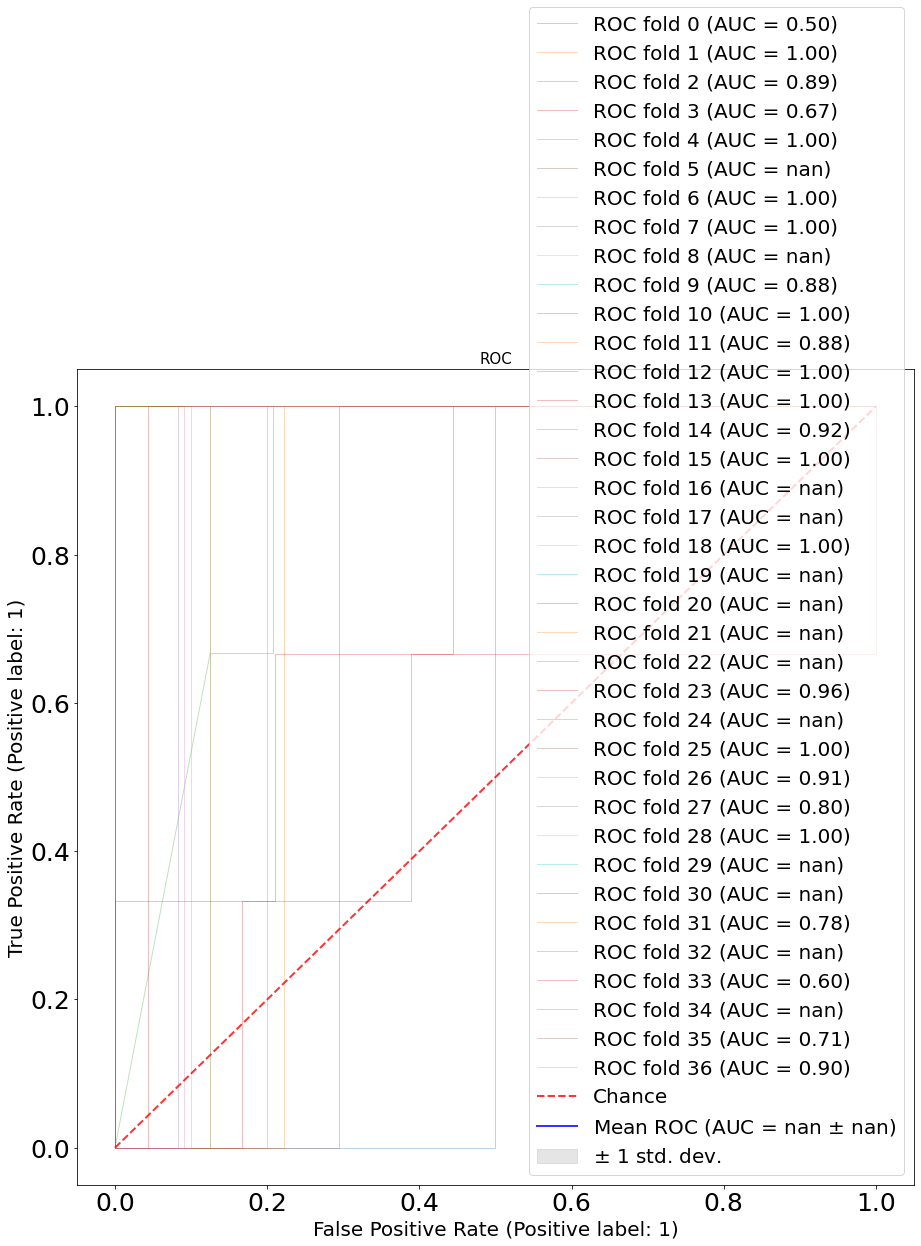

[[282. 122.]
 [  6.  29.]]
accuracy 0.7084282460136674
TP 0.9791666666666666
TN 0.19205298013245034
FP 0.8079470198675497
FN 0.020833333333333332
       OL  detected  0 FP  1 FP  2 FP  3 FP  >3 FP  FalNeg  TruNeg
IIA     8         8     0     0     0     0      0       0       0
IIB     9         9     1     0     0     0      0       0       0
mMCD    5         4     0     0     0     0      0       0       0
MOGHE   2         2     0     0     0     0      0       0       0


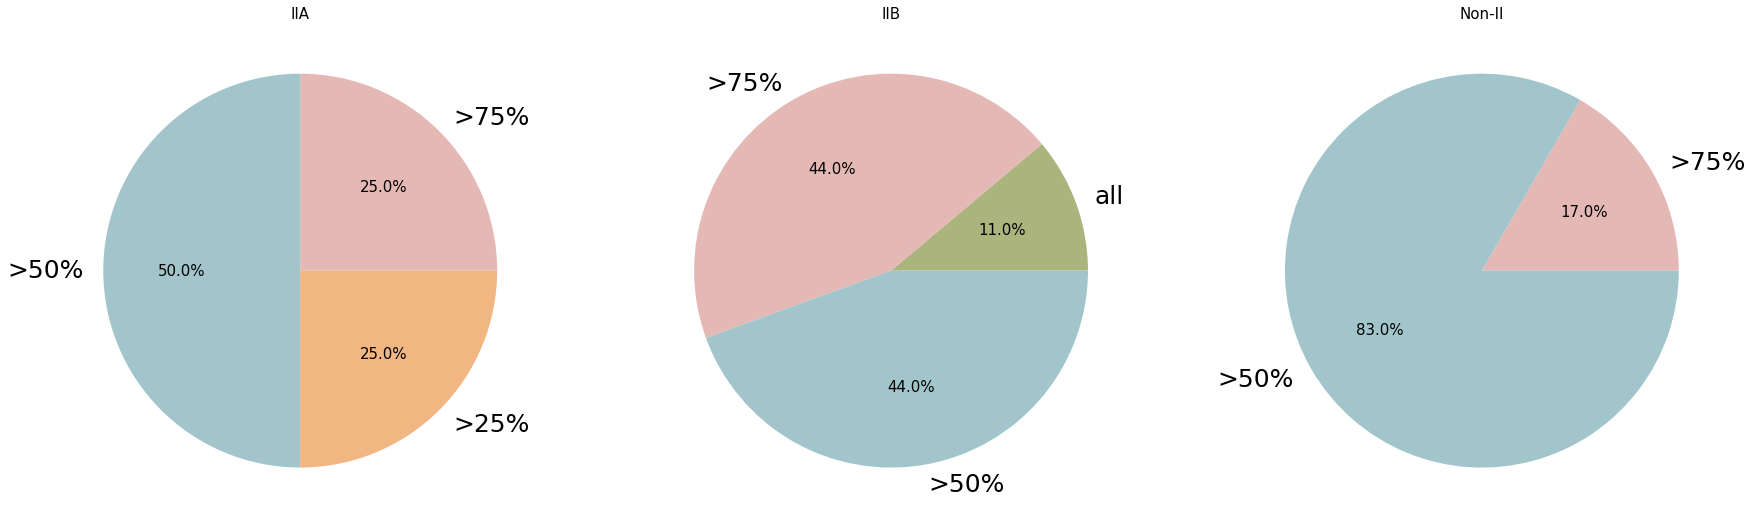

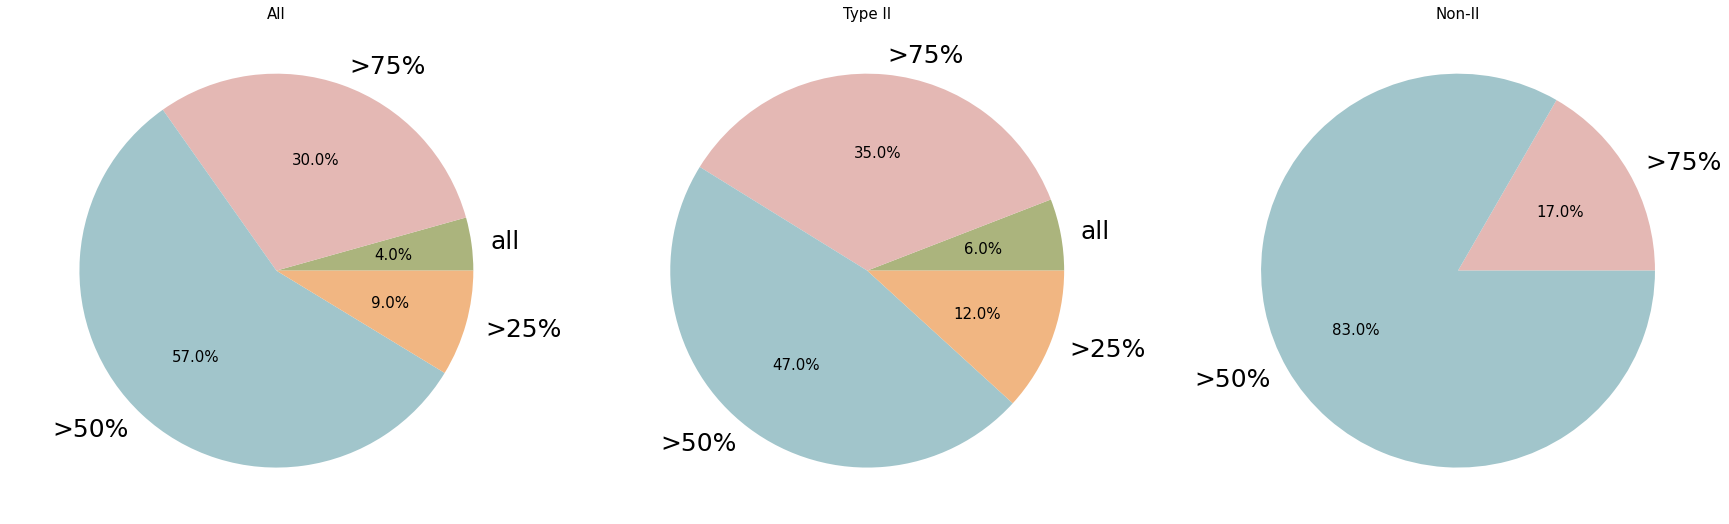

In [131]:
%cd /Volumes/eegrvw/Imaging/Multimodal/MRF/Recon_MRF_3T/Patients/P102_15731/MRF_VBM
vrange = np.arange(1,2)

bytypesum = {'IIA':{'OL':0, 'detected':0, 'all':0, '>75%':0, '>50%':0,'>25%':0 ,'0~25%': 0}, 
             'IIB':{'OL':0, 'detected':0, 'all':0, '>75%':0, '>50%':0,'>25%':0,'0~25%': 0}, 
             'mMCD':{'OL':0, 'detected':0, 'all':0, '>75%':0, '>50%':0,'>25%':0,'0~25%': 0},
             'MOGHE':{'OL':0, 'detected':0, 'all':0, '>75%':0, '>50%':0,'>25%':0,'0~25%': 0} 
           }
typecount = {'IIA':{'OL':0, 'detected':0, '0 FP':0, '1 FP':0, '2 FP':0,'3 FP':0, '>3 FP':0, 'FalNeg':0, 'TruNeg':0}, 
           'IIB':{'OL':0, 'detected':0, '0 FP':0, '1 FP':0, '2 FP':0,'3 FP':0, '>3 FP':0, 'FalNeg':0, 'TruNeg':0}, 
           'mMCD':{'OL':0, 'detected':0, '0 FP':0, '1 FP':0, '2 FP':0,'3 FP':0, '>3 FP':0, 'FalNeg':0, 'TruNeg':0}, 
           'MOGHE':{'OL':0, 'detected':0, '0 FP':0, '1 FP':0, '2 FP':0,'3 FP':0, '>3 FP':0, 'FalNeg':0, 'TruNeg':0}}

for vth in vrange:
    # X = pd.read_excel('norm_trainingatpoint0old.xlsx').values[:,0:5]
    # # np.delete(X,[53, 265, 284, 334, 347],0)
    # y = pd.read_excel('norm_trainingatpoint0old.xlsx').values[:,8].astype(int)
    # pts = pd.read_excel('norm_trainingatpoint0old.xlsx').values[:,6]
    # sutys = pd.read_excel('norm_trainingatpoint0old.xlsx').values[:,7]
    X = pd.read_excel('norm_trainingatpoint0old_Bronly.xlsx').values[:,0:6]
    y = pd.read_excel('norm_trainingatpoint0old_Bronly.xlsx').values[:,8].astype(int)
    pts = pd.read_excel('norm_trainingatpoint0old_Bronly.xlsx').values[:,6]
    sutys = pd.read_excel('norm_trainingatpoint0old_Bronly.xlsx').values[:,7]
#     X = pd.read_excel('preds_norm_1.xlsx').values[:,0:5]
#     y = pd.read_excel('preds_norm_1.xlsx').values[:,8].astype(int)
#     pts = pd.read_excel('preds_norm_1.xlsx').values[:,6]
#     sutys = pd.read_excel('preds_norm_1.xlsx').values[:,7]
    
#     X = pd.read_excel('oldtrainingdata.xltx').values[:,0:5]
#     y = pd.read_excel('oldtrainingdata.xltx').values[:,8].astype(int)
#     pts = pd.read_excel('oldtrainingdata.xltx').values[:,6]
#     sutys = pd.read_excel('oldtrainingdata.xltx').values[:,7]

    
    
    tot_patient = 0
    det_tp = 0
    det_fp_0 = 0
    det_fp_1 = 0
    det_fp_2 = 0
    det_fp_3 = 0
    det_fp_4 = 0
    det_fn = 0
    det_tn = 0
    

    logo = LeaveOneGroupOut()
    y = y.reshape(-1,)
    pts = pts.reshape(-1,)
    GlobalRandomStateSeed=123

#     classifier=svm.SVC(kernel='linear', probability=False,
#                          random_state=GlobalRandomStateSeed)
    steps = [('over', SMOTE()), ('model',  svm.SVC(kernel="linear", probability=True,
                         random_state=GlobalRandomStateSeed))]
    from sklearn.neural_network import MLPClassifier
    mlp = MLPClassifier(hidden_layer_sizes=(10,10), max_iter=3000, activation = 'tanh',solver='adam',learning_rate='adaptive', random_state=123)
    steps = [('over', ADASYN()), ('mlpc', mlp)]
    pipeline = Pipeline(steps=steps)
    tprs = []
    aucs = []
    cm = np.zeros((2,2))
    mean_fpr = np.linspace(0, 1, 100)

    fig, ax = plt.subplots(figsize=(15, 15))
    for i, (train, test) in enumerate(logo.split(X, y, pts)):

        pipeline.fit(X[train], y[train])
        viz = RocCurveDisplay.from_estimator(pipeline, X[test], y[test],
                             name='ROC fold {}'.format(i),
                             alpha=0.3, lw=1, ax=ax)
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)
        threshold = 0.3
        y_pred = (pipeline.predict_proba(X[test])[:, 1] > threshold).astype('float')

#         y_pred = pipeline.predict(X[test])

        print(f'Patient: {pts[test][0]}, Subtype: {sutys[test][0]}, Truth: {y[test]}, Prediction: {y_pred}')
        if sum(y[test]) > 0:
            tot_patient += 1
            bytypesum[sutys[test][0]]['OL'] +=1 
            typecount[sutys[test][0]]['OL'] +=1 
            detect = (y[test] + y_pred) == 2
            detect_fp = (y[test] - y_pred) == -1
            detect_fn =(y[test] - y_pred) == 1
            if sum(detect) > 0:
                det_tp += 1
                bytypesum[sutys[test][0]]['detected'] +=1
                typecount[sutys[test][0]]['detected'] +=1  
                if sum(detect_fp) == 0:
                    bytypesum[sutys[test][0]]['all'] +=1
                    typecount[sutys[test][0]]['0 FP'] +=1                                
                elif sum(detect_fp)/(y[test].shape[0]-y[test].sum()) <= 0.25:
                    det_fp_1 += 1
                    bytypesum[sutys[test][0]]['>75%'] +=1 
                elif sum(detect_fp)/(y[test].shape[0]-y[test].sum()) <= 0.5:
                    det_fp_2 += 1
                    bytypesum[sutys[test][0]]['>50%'] +=1 
                elif sum(detect_fp)/(y[test].shape[0]-y[test].sum()) <= 0.75:
                    det_fp_3 += 1
                    bytypesum[sutys[test][0]]['>25%'] +=1
                elif sum(detect_fp)/(y[test].shape[0]-y[test].sum()) <= 1:
                    det_fp_4 += 1
                    bytypesum[sutys[test][0]]['0~25%'] +=1

            else:
              print("not detected")

            # det_fp_0 = det_tp - det_fp_1 - det_fp_2- det_fp_3 - det_fp_4
            # bytypesum[sutys[test][0][0]]['0 FP'] = det_fp_0

        if sum(y[test]) == 0:
            if sum(y[test] + y_pred) == 0:
                det_tn += 1
                
        cm += confusion_matrix(y[test], y_pred)

    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
            label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
            label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
            lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')

    plt.rc('font', size=15)          # controls default text sizes
    plt.rc('axes', titlesize=15)     # fontsize of the axes title
    plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=25)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=25)    # fontsize of the tick labels
    plt.rc('legend', fontsize=20)    # legend fontsize
    plt.rc('figure', titlesize=20)  # fontsize of the figure title
    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
           title="ROC")
    ax.legend(loc="lower right")
    plt.show()
    print(cm)
    print('accuracy',(cm[0,0]+cm[1,1])/np.sum(cm))
    print('TP',(cm[0,0])/(cm[0,0]+cm[1,0]))
    print('TN',(cm[1,1])/(cm[1,1]+cm[0,1]))
    print('FP',(cm[0,1])/(cm[1,1]+cm[0,1]))
    print('FN',(cm[1,0])/(cm[1,0]+cm[0,0]))

    df = pd.DataFrame(bytypesum).T
    df1 = df.iloc[0:4,2:]
    df1.loc['mMCD'] += df1.loc['MOGHE']
    df1.drop(['MOGHE'], inplace=True)
    df1.T.plot.pie(subplots=True, figsize=(30, 20), legend = False, ylabel = ' ', title = ['IIA', 'IIB', 'Non-II'], autopct=lambda p: '{:.1f}%'.format(round(p)) if p > 0 else '', colors = copa)

    a  = df1.loc['mMCD'] + df1.loc['IIA'] + df1.loc['IIB']
    new_row = pd.DataFrame([a],index=['all'],columns=df1.columns)
    df2 = pd.concat([new_row, df1.loc[:]])
    df2.loc['IIA'] += df2.loc['IIB']
    df2.drop(['IIB'], inplace=True)
    df2.T.plot.pie(subplots=True, figsize=(30, 20), legend = False, ylabel = ' ', title = ['All', 'Type II', 'Non-II'], autopct=lambda p: '{:.1f}%'.format(round(p)) if p > 0 else '', colors = copa)

    df3 = pd.DataFrame(typecount).T
    print(df3)

array([<AxesSubplot:title={'center':'All'}, ylabel=' '>,
       <AxesSubplot:title={'center':'Type II'}, ylabel=' '>,
       <AxesSubplot:title={'center':'Non-II'}, ylabel=' '>], dtype=object)

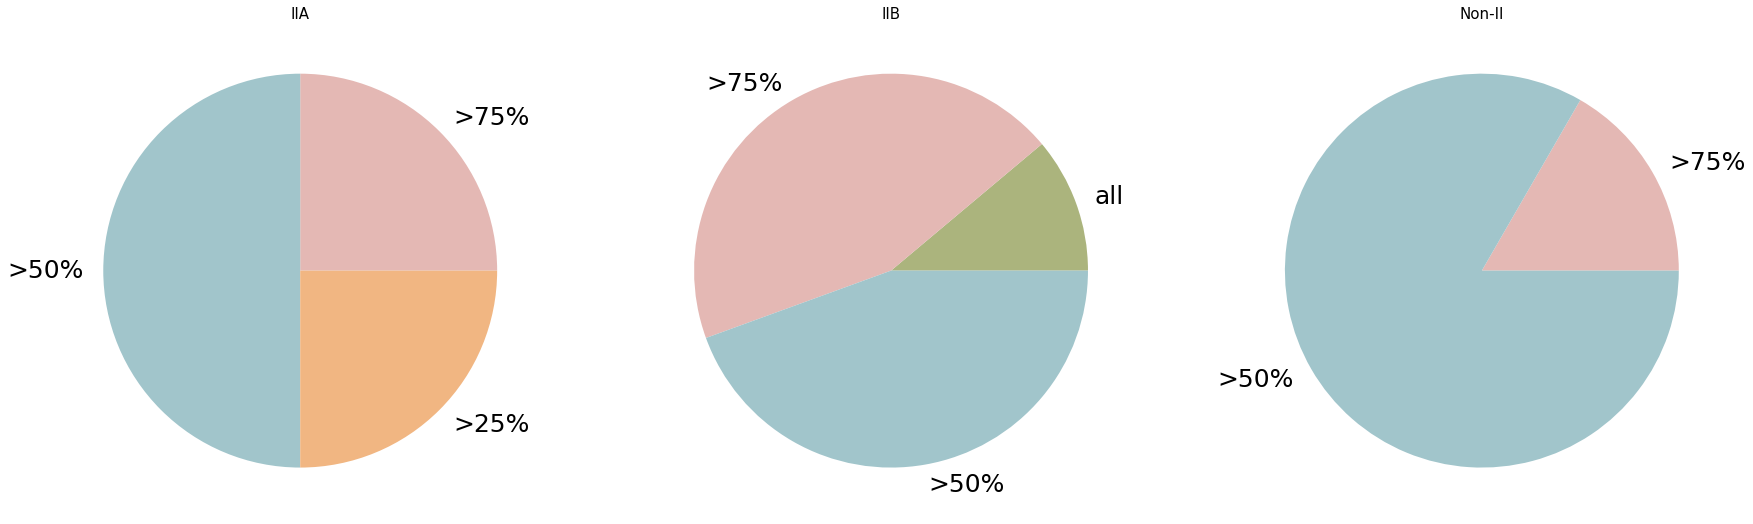

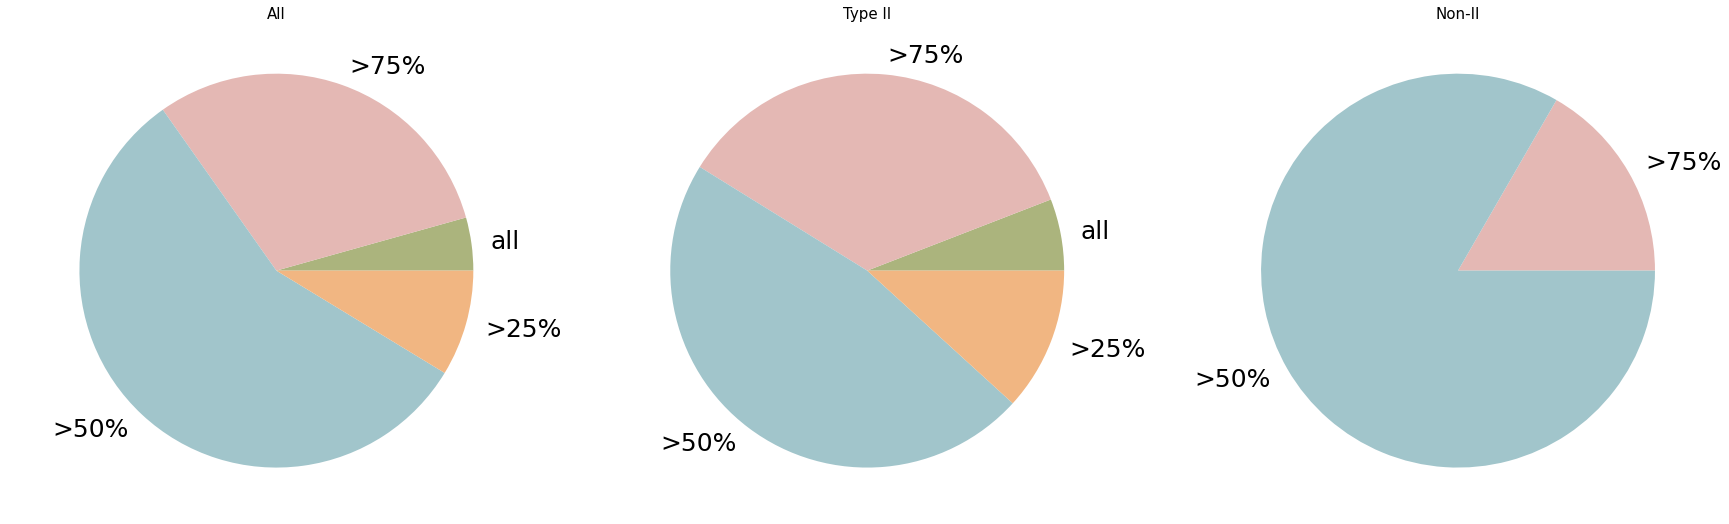

In [132]:
df1.T.plot.pie(subplots=True, figsize=(30, 20), legend = False, ylabel = ' ', title = ['IIA', 'IIB', 'Non-II'], colors = copa)
df2.T.plot.pie(subplots=True, figsize=(30, 20), legend = False, ylabel = ' ', title = ['All', 'Type II', 'Non-II'], colors = copa)

Z:\Imaging\Multimodal\MRF\Recon_MRF_3T\Patients\P102_15731\MRF_VBM
Patient: P100_15582, Subtype: mMCD, Truth: [0 0 1 0 0], Prediction: [0. 0. 0. 0. 0.]
Patient: P101_15675, Subtype: IIB, Truth: [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0], Prediction: [0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0.]
Patient: P102_15731, Subtype: mMCD, Truth: [0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0], Prediction: [1. 1. 1. 1. 0. 0. 0. 1. 0. 1. 1. 1. 1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0.
 0. 1. 0.]
Patient: P10_12479, Subtype: MOGHE, Truth: [0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0], Prediction: [1. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0.]
Patient: P11_12483, Subtype: IIB, Truth: [0 0 0 0 0 0 0 0 0 1 0 0 0], Prediction: [1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 1. 1. 1.]
Patient: P12_12515, Subtype: mMCD, Truth: [0 0 0 0 0 0], Prediction: [0. 1. 0. 0. 0. 0.]
Patient: P15_12610, Subtype: IIB, T

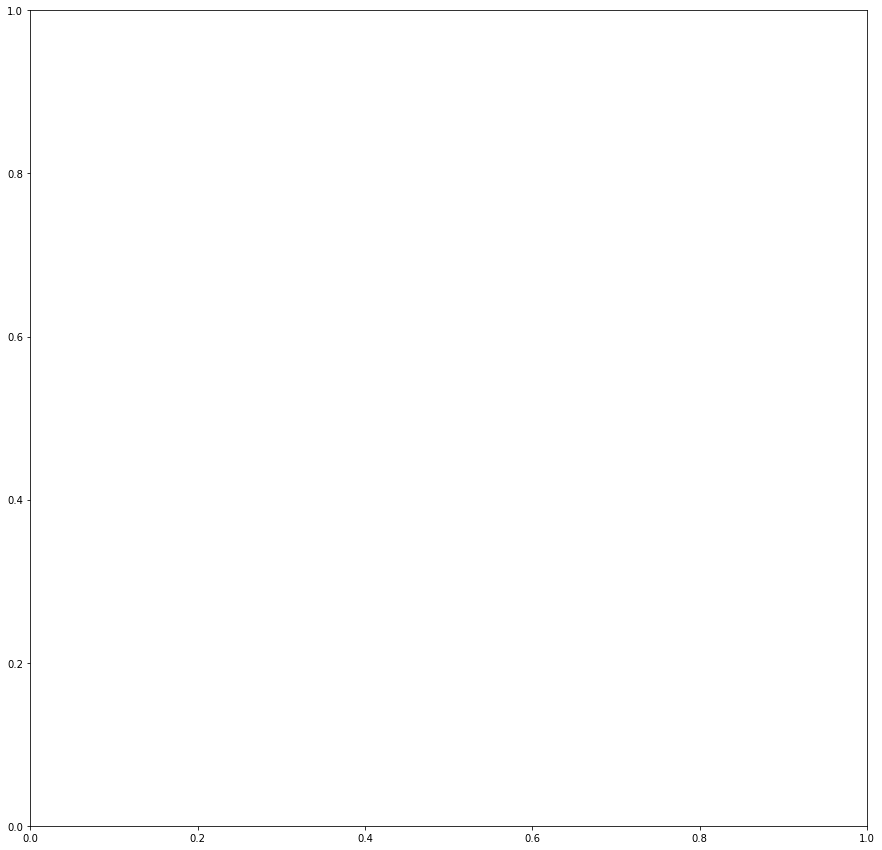

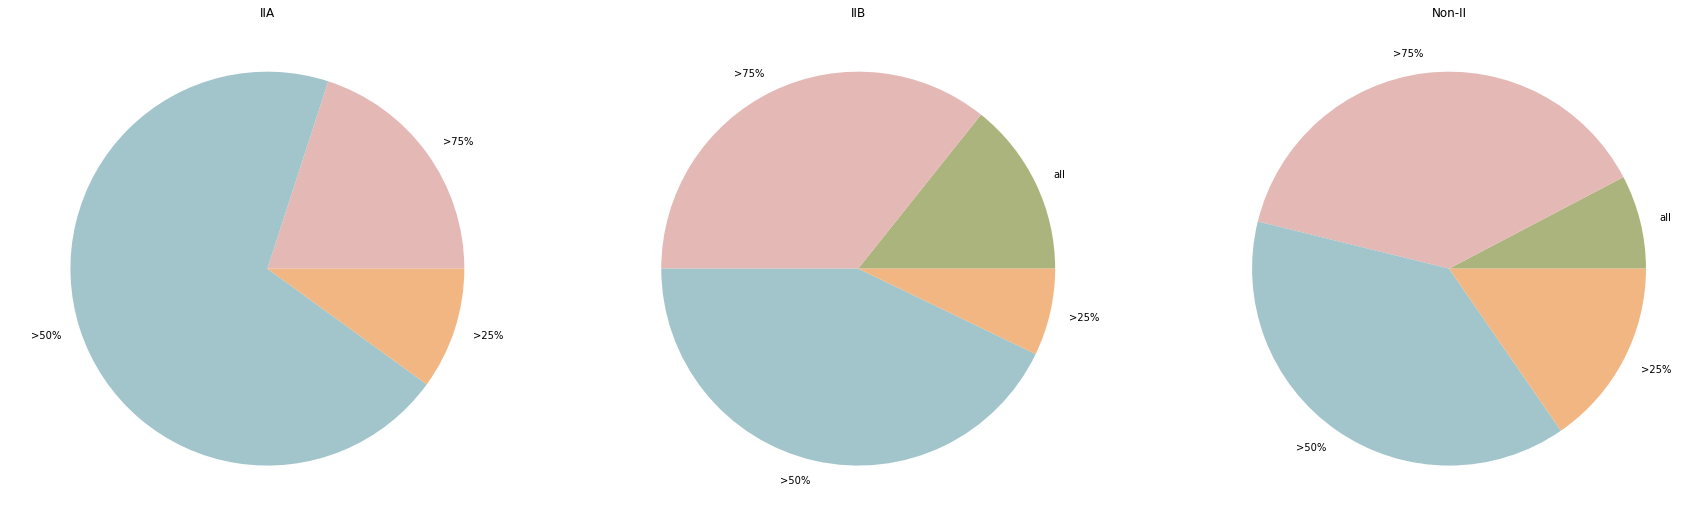

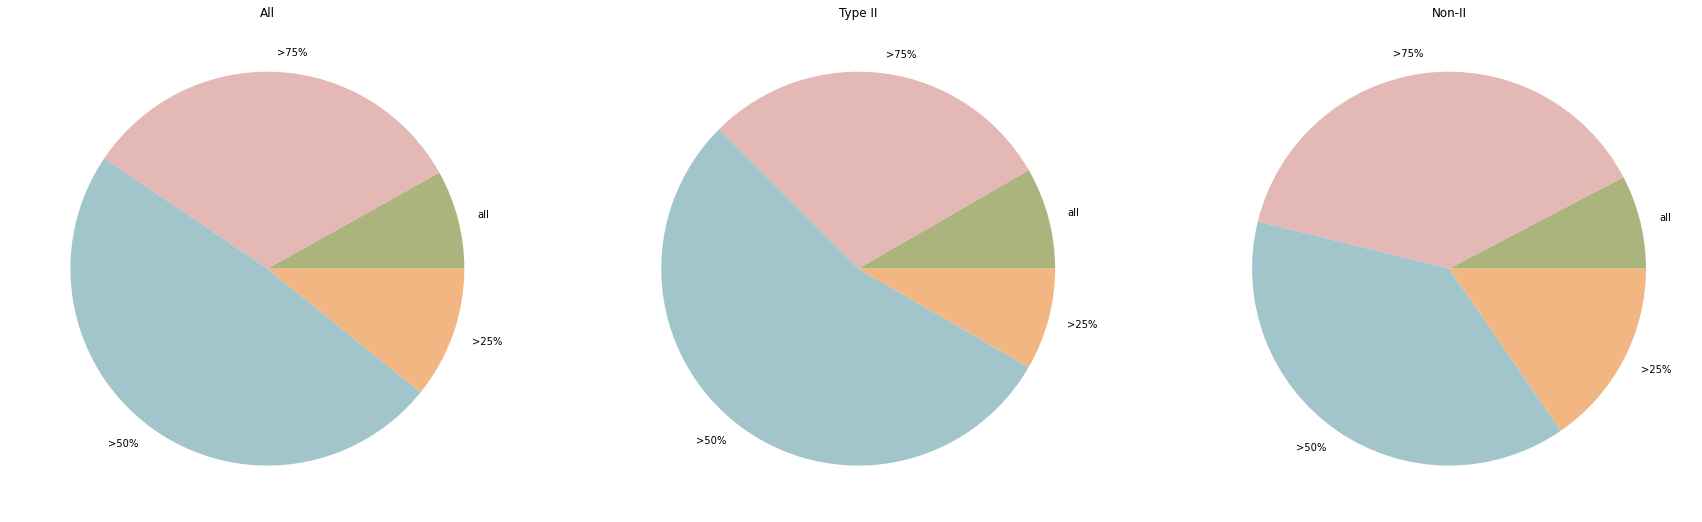

In [7]:
## final analysis patient level with pie charts on all patients (not just over lapped)
%cd Z:\Imaging\Multimodal\MRF\Recon_MRF_3T\Patients\（studyID）\MRF_VBM

vrange = np.arange(1,2)

bytypesum = {'IIA':{'OL':0, 'detected':0, 'all':0, '>75%':0, '>50%':0,'>25%':0}, 
             'IIB':{'OL':0, 'detected':0, 'all':0, '>75%':0, '>50%':0,'>25%':0}, 
             'mMCD':{'OL':0, 'detected':0, 'all':0, '>75%':0, '>50%':0,'>25%':0},
             'MOGHE':{'OL':0, 'detected':0, 'all':0, '>75%':0, '>50%':0,'>25%':0} 
           }

for vth in vrange:
    X = pd.read_excel('norm_trainingatpoint0old_Bronly.xlsx').values[:,0:6]
    y = pd.read_excel('norm_trainingatpoint0old_Bronly.xlsx').values[:,8].astype(int)
    pts = pd.read_excel('norm_trainingatpoint0old_Bronly.xlsx').values[:,6]
    sutys = pd.read_excel('norm_trainingatpoint0old_Bronly.xlsx').values[:,7]
    
    tot_patient = 0
    det_tp = 0
    det_fp_0 = 0
    det_fp_1 = 0
    det_fp_2 = 0
    det_fp_3 = 0
    det_fp_4 = 0
    det_fn = 0
    det_tn = 0
    

    logo = LeaveOneGroupOut()
    y = y.reshape(-1,)
    pts = pts.reshape(-1,)
    GlobalRandomStateSeed=123

#     classifier=svm.SVC(kernel='linear', probability=True,
#                          random_state=GlobalRandomStateSeed)
#     steps = [('over', SMOTE()), ('model',  svm.SVC(kernel="linear"))]
    mlp = MLPClassifier(hidden_layer_sizes=(10,10), max_iter=3000, activation = 'tanh',solver='adam',learning_rate='adaptive', random_state=123)
    steps = [('over', ADASYN()), ('mlpc', mlp)]
    pipeline = Pipeline(steps=steps)
    tprs = []
    aucs = []
    cm = np.zeros((2,2))
    mean_fpr = np.linspace(0, 1, 100)

    fig, ax = plt.subplots(figsize=(15, 15))
    for i, (train, test) in enumerate(logo.split(X, y, pts)):

        pipeline.fit(X[train], y[train])

        threshold = 0.3
        y_pred = (pipeline.predict_proba(X[test])[:, 1] > threshold).astype('float')

        print(f'Patient: {pts[test][0]}, Subtype: {sutys[test][0]}, Truth: {y[test]}, Prediction: {y_pred}')
        detect = (y[test] + y_pred) == 2
        detect_fp = (y[test] - y_pred) == -1
        detect_fn =(y[test] - y_pred) == 1

        if sum(detect_fp) == 0:
            bytypesum[sutys[test][0]]['all'] +=1                               
        elif sum(detect_fp)/(y[test].shape[0]-y[test].sum()) <= 0.25:
            det_fp_1 += 1
            bytypesum[sutys[test][0]]['>75%'] +=1 
        elif sum(detect_fp)/(y[test].shape[0]-y[test].sum()) <= 0.5:
            det_fp_2 += 1
            bytypesum[sutys[test][0]]['>50%'] +=1 
        elif sum(detect_fp)/(y[test].shape[0]-y[test].sum()) <= 0.75:
            det_fp_3 += 1
            bytypesum[sutys[test][0]]['>25%'] +=1
    
    copa = ['#abb47d', '#e4b8b4', '#a1c5cb', '#f1b682', '#ffde76']
    df = pd.DataFrame(bytypesum).T
    df1 = df.iloc[0:4,2:]
    df1.loc['mMCD'] += df1.loc['MOGHE']
    df1.drop(['MOGHE'], inplace=True)
    df1.T.plot.pie(subplots=True, figsize=(30, 20), legend = False, ylabel = ' ', title = ['IIA', 'IIB', 'Non-II'], colors = copa)

    a  = df1.loc['mMCD'] + df1.loc['IIA'] + df1.loc['IIB']
    new_row = pd.DataFrame([a],index=['all'],columns=df1.columns)
    df2 = pd.concat([new_row, df1.loc[:]])
    df2.loc['IIA'] += df2.loc['IIB']
    df2.drop(['IIB'], inplace=True)
    df2.T.plot.pie(subplots=True, figsize=(30, 20), legend = False, ylabel = ' ', title = ['All', 'Type II', 'Non-II'], colors = copa)

array([<AxesSubplot:title={'center':'All'}, ylabel=' '>,
       <AxesSubplot:title={'center':'Type II'}, ylabel=' '>,
       <AxesSubplot:title={'center':'Non-II'}, ylabel=' '>], dtype=object)

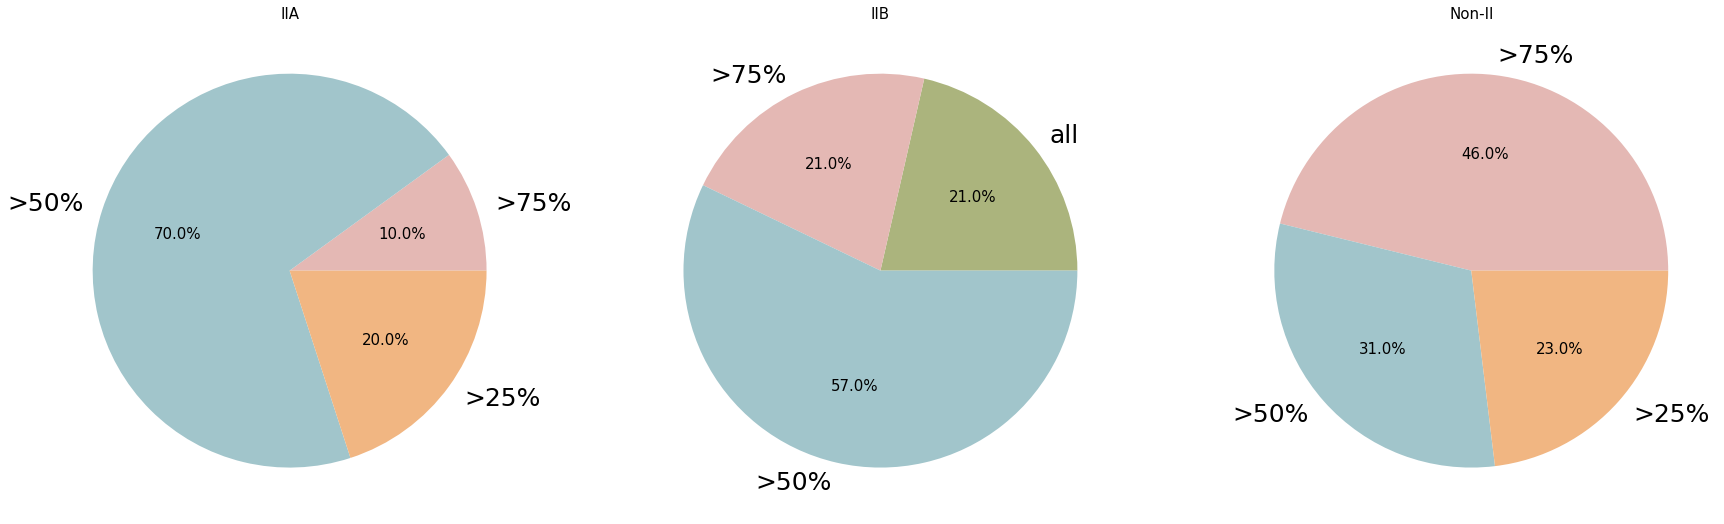

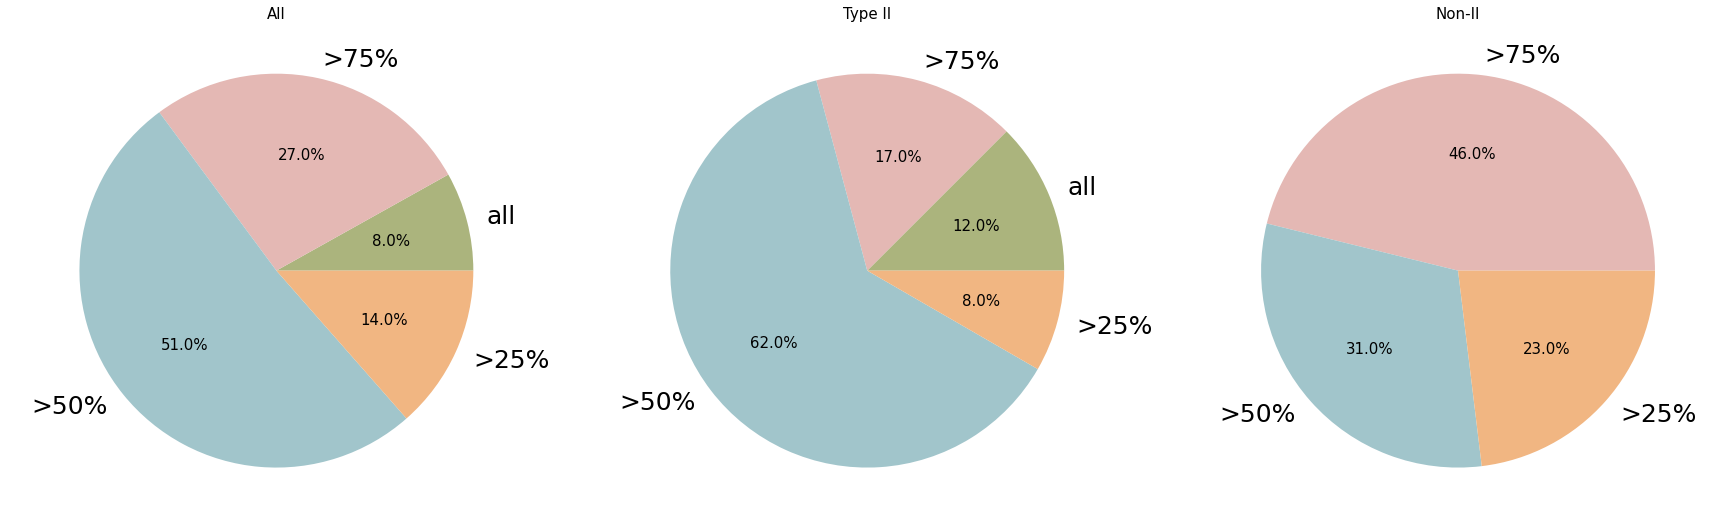

In [134]:
df1.T.plot.pie(subplots=True, figsize=(30, 20), legend = False, ylabel = ' ', title = ['IIA', 'IIB', 'Non-II'], colors = copa, autopct=lambda p: '{:.1f}%'.format(round(p)) if p > 0 else '')
df2.T.plot.pie(subplots=True, figsize=(30, 20), legend = False, ylabel = ' ', title = ['All', 'Type II', 'Non-II'], colors = copa, autopct=lambda p: '{:.1f}%'.format(round(p)) if p > 0 else '')